In [ ]:
# MIT License
#
#@title Copyright (c) 2021 CCAI Community Authors { display-mode: "form" }
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Predicting Mobility Demand From Urban Features

Author(s):
*   Konstantin Klemmer, Microsoft Research & CCAI, konstantin@climatechange.ai
*   Shafat Rahman, CCAI, shafatrahman@climatechange.ai
*   Felix Wagner, TU Berlin & Mercator Research Institute on Global Commons and Climate Change, wagner@mcc-berlin.net



# Table of Contents


*   [Overview](#overview)
*   [Climate Impact](#climate-impact)
*   [Background & Prerequisites](#background-and-prereqs)
*   [Software Requirements](#software-requirements)
*   [Data Description](#data-description)
*   [Methodology](#methodology)
*   [Results & Discussion](#results-and-discussion)
*   [References](#references)


<a name="overview"></a>
# Overview

In this tutorial we investigate the relationship between urban features, such as the location of different businesses and services, and bike-sharing demand in Shenzhen. From a dataset of shared-bike trips in Shenzhen, we compute kernel density estimates of trip end points and points of interest such as medical services, transportation services, etc. Then we apply linear regression and a graph neural network to model the relationship between POI densities and trip ending densities.

<a name="climate-impact"></a>
# Climate Impact

Studying bike-sharing data could help us determine the demand for shared bikes at different locations at different times of day and days of the week. This information can be used to make sure that enough bikes are available at bike stands during hours of peak demand, hence ensuring that commuters do not turn to less climate-friendly greenhouse gas-emitting modes of transportation because of a lack of shared bikes.

Modeling the relationship between bike usage and POIs can also inform where to set up new shared-bike stands. For example, if a lot of people prefer to bike to public transportation services, new shared-bike stands could be installed at bus and train stations that do not have shared-bike coverage.

Investigating areas with low shared-bike demand can reveal issues such as lack of bike lanes that are keeping more people from adopting greener transportation habits.

<a name="background-and-prereqs"></a>
# Background & Prerequisites

To get the most out of this tutorial, you should have a basic understanding of data processing and cleaning. Familiarity with handling spatial data such are latitude and longitude coordinates will be helpful.

You should also be familiar with simple modeling techniques such as linear regression.




<a name="software-requirements"></a>
# Software Requirements
This tutorial was developed using Python 3.7.14.

Below we will import the python libraries necessary for this tutorial. Some libraries have to be installed because they are not automatically available in Colab's Python environment.

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
import shutil

%matplotlib inline

In [ ]:
!pip install geopandas
import geopandas as gpd

In [ ]:
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 28.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


<a name="data-description"></a>
# Data Description

Our data include:
* Shape files specifying locations of points of interest (POI) in folder ShenzhenPOI/ShapeFile. The filenames of the shape files include the POI category.
* The shenzhenPOI folder also contains an excel file called amap_poicode.xlsx which contains translations of POI category names from Chinese to English.
* Trip data from 2021 in the folder called 8.01-8.30.
* Shape files for Shenzhen, Shenzhen's population distribution, Shenzhen's bus and metro stops


## Data Download
Our data is stored in a public Google Drive folder at https://drive.google.com/drive/u/3/folders/18bdGh6IIRhqKr3gPQhbuhkOgZykBrfqx. We can download the data using gdown.

The data download and extraction below should not take more than 5 minutes.

In [ ]:
!gdown --folder --remaining-ok https://drive.google.com/drive/u/3/folders/1sLp2mWlBMX3mRnkTAzHcMBStCXLK2KDN -O /content/data/

Retrieving folder list
Retrieving folder 1OinJcYU7BfJDrzE8AlTrHtdC9GDgjrw7 8.01-8.30
Processing file 1ROAzky8XOtq40FdrvO4_4iHMIfzUw40s shared_bike_data.zip
Retrieving folder 1Urx8M4i-XurgPGW43XghYQQ-jVVuLzn7 bus_metro
Retrieving folder 1uJBsF_UvqCZaLBpzMG_wEzGKG6atnVDR bus_station_shp
Processing file 1uYb-CvKS2FkqJVnYlTqiI7Oj74vShRqM bus_station_point.cpg
Processing file 1yGA8KxI7M7WCv69qHxr08qbzmoQkxMwP bus_station_point.dbf
Processing file 1xBJT7SjjYbDfn3_zlafsBkiklgeglL6N bus_station_point.prj
Processing file 1fjo9sWAy4_6rKnThJkLFOvzJO1nUurxb bus_station_point.shp
Processing file 17CqgxB8Hw7RzjRjCfwYIbFC8mcH9c-zh bus_station_point.shx
Processing file 1Ai7IawCgQgVCdtdatBrmfS1XkDz4WOP- metro_area.csv
Retrieving folder 118YyeAwzcDbA_Zq7kjKS3jYNburXQt_G pop
Processing file 1w1dZjxoRaWDAmmB7tmG8WSDU6Rs3cqT4 pop_shenzhen.tif
Processing file 1Mbylsw2F9Thc1wQgayZgADFV2tkakeZz pop.cpg
Processing file 166jNIIRqz3CqRo4B5ZrP_E17ey__JBvt pop.dbf
Processing file 1zo2yGRzmsm82xTeqLRN_lv9FI0sASqKk 

The trip start and end data are stored in csv files within a compressed file called shared_bike_data.zip. We start by unzipping the file.

In [ ]:
!unzip '/content/data/Shenzhen Bike-Share Data/8.01-8.30/shared_bike_data.zip' -d '/content/data/Shenzhen Bike-Share Data/8.01-8.30/'

Archive:  /content/data/Shenzhen Bike-Share Data/8.01-8.30/shared_bike_data.zip
   creating: /content/data/Shenzhen Bike-Share Data/8.01-8.30/shared_bike_data/
  inflating: /content/data/Shenzhen Bike-Share Data/8.01-8.30/__MACOSX/._shared_bike_data  
  inflating: /content/data/Shenzhen Bike-Share Data/8.01-8.30/shared_bike_data/21_1000w.csv  
  inflating: /content/data/Shenzhen Bike-Share Data/8.01-8.30/__MACOSX/shared_bike_data/._21_1000w.csv  
  inflating: /content/data/Shenzhen Bike-Share Data/8.01-8.30/shared_bike_data/22_1000w.csv  
  inflating: /content/data/Shenzhen Bike-Share Data/8.01-8.30/__MACOSX/shared_bike_data/._22_1000w.csv  
  inflating: /content/data/Shenzhen Bike-Share Data/8.01-8.30/shared_bike_data/24_1000w.csv  
  inflating: /content/data/Shenzhen Bike-Share Data/8.01-8.30/__MACOSX/shared_bike_data/._24_1000w.csv  
  inflating: /content/data/Shenzhen Bike-Share Data/8.01-8.30/shared_bike_data/23_1000w.csv  
  inflating: /content/data/Shenzhen Bike-Share Data/8.01-

The shape files that define points of interest (POIs) are stored in a compressed file called ShapeFile.zip. POIs are urban features such as restaurants, hospitals, bus stations, stadiums, etc. The shape files store spatial information about the POIs, for example, their latitude and longitude coordinates.

In [ ]:
!unzip '/content/data/Shenzhen Bike-Share Data/ShenzhenPOI/ShapeFile.zip' -d '/content/data/Shenzhen Bike-Share Data/ShenzhenPOI/'

Archive:  /content/data/Shenzhen Bike-Share Data/ShenzhenPOI/ShapeFile.zip
   creating: /content/data/Shenzhen Bike-Share Data/ShenzhenPOI/ShapeFile/
  inflating: /content/data/Shenzhen Bike-Share Data/ShenzhenPOI/__MACOSX/._ShapeFile  
  inflating: /content/data/Shenzhen Bike-Share Data/ShenzhenPOI/ShapeFile/shenzhen_MotorcycleService_20220602_033442.dbf  
  inflating: /content/data/Shenzhen Bike-Share Data/ShenzhenPOI/__MACOSX/ShapeFile/._shenzhen_MotorcycleService_20220602_033442.dbf  
  inflating: /content/data/Shenzhen Bike-Share Data/ShenzhenPOI/ShapeFile/shenzhen_AutoRepair_20220602_033427.cpg  
  inflating: /content/data/Shenzhen Bike-Share Data/ShenzhenPOI/__MACOSX/ShapeFile/._shenzhen_AutoRepair_20220602_033427.cpg  
  inflating: /content/data/Shenzhen Bike-Share Data/ShenzhenPOI/ShapeFile/shenzhen_AutoRepair_20220602_033427.shp  
  inflating: /content/data/Shenzhen Bike-Share Data/ShenzhenPOI/__MACOSX/ShapeFile/._shenzhen_AutoRepair_20220602_033427.shp  
  inflating: /conten

## Data Preprocessing

Let's begin by loading a subset of the trip data to a pandas dataframe. We choose the csv file called 21_1000w.

Since the csv files have many rows of data, running this tutorial with all the data will be time-consuming. So we are working with a subset. If you are interested, it could be a good exercise to run this tutorial using all the data.

In [ ]:
df = pd.read_csv('data/Shenzhen Bike-Share Data/8.01-8.30/shared_bike_data/21_1000w.csv')

In [ ]:
df.count()

Unnamed: 0    9980998
_id           9980998
START_TIME    9980998
START_LAT     9980998
END_TIME      9980998
END_LNG       9980998
USER_ID       9980998
START_LNG     9980998
END_LAT       9980998
dtype: int64

As you can see, the dataframe has close to 10 million entries! In this tutorial we will work with the first 100,000 entries. This will allow us to train our models within a reasonable amount of time.

In [ ]:
df = df[:100000]

Next, let's take a look at what attributes our trip data has by printing the first couple of rows.

In [ ]:
df.head()

,Unnamed: 0,_id,START_TIME,START_LAT,END_TIME,END_LNG,USER_ID,START_LNG,END_LAT
0,0,6235d85fd9eb0867d7831fa6,2021-07-31 12:41:44.0,22.507981,2021-07-31 12:45:11.0,113.919257,78da6e0fd3dfbeff3cd463**********,113.920758,22.507992
1,1,6235d85fd9eb0867d7831fa7,2021-07-31 12:32:58.0,22.540632,2021-07-31 12:45:33.0,113.952192,ce54285f794647592bd215**********,113.952858,22.556025
2,2,6235d85fd9eb0867d7831fa8,2021-07-31 12:30:49.0,22.598146,2021-07-31 12:45:33.0,114.132412,0074a337381b8df756bf40**********,114.111139,22.591252
3,3,6235d85fd9eb0867d7831fa9,2021-07-31 12:39:55.0,22.635534,2021-07-31 12:45:28.0,114.060077,4041593ac4bc37a9634018**********,114.064085,22.639093
4,4,6235d85fd9eb0867d7831faa,2021-07-31 12:30:49.0,22.598078,2021-07-31 12:45:33.0,114.132344,6d3ae0b95a635246402402**********,114.111070,22.591184


We can see that the data consists of start and end times and coordinates of the trips. Next, let's print out the range, min and max of each attribute:

In [ ]:
pd.DataFrame({
    'count': df.count(),
    'min': df.min(),
    'max': df.max()
})

,count,min,max
Unnamed: 0,100000,0,99999
_id,100000,6235d85fd9eb0867d7831fa6,6235d8ddd9eb0867d784a645
START_TIME,100000,2021-07-28 16:02:55.0,2021-07-31 14:24:10.0
START_LAT,100000,0.0,47.212415
END_TIME,100000,2021-07-28 16:06:47.0,2021-07-31 14:24:31.0
END_LNG,100000,0.0,116.095196
USER_ID,100000,0000794fcc21c8159e8f85**********,ffff55c901784ab0963fa5**********
START_LNG,100000,0.0,131.97938
END_LAT,100000,0.0,23.42264


The summary above shows that our data is from the last four days of July 2021. We also notice that the some trips start and/or end at 0.0 coordinates. This is clearly erroneous since Shenzhen's longitude range is approximately between 113.7 to 114.7 and latitude range is between 22.0 and 23.0. We should drop all trips that start and end outside Shenzhen.

In [ ]:
# selecting approx coordinates around Shenzhen
longitude_range = [113.7, 114.7]
latitude_range = [22.0, 23.0]

col_to_range_map = {"START_LAT" : latitude_range,
                    "START_LNG" : longitude_range,
                    "END_LAT" : latitude_range,
                    "END_LNG" : longitude_range
                    }

for col, range in col_to_range_map.items():
    df.drop(df[(df[col] > range[1]) | (df[col] < range[0])].index, inplace=True)

pd.DataFrame({
    'count': df.count(),
    'min': df.min(),
    'max': df.max()
})

,count,min,max
Unnamed: 0,99895,0,99999
_id,99895,6235d85fd9eb0867d7831fa6,6235d8ddd9eb0867d784a645
START_TIME,99895,2021-07-28 16:02:55.0,2021-07-31 14:24:10.0
START_LAT,99895,22.45544,22.865427
END_TIME,99895,2021-07-28 16:06:47.0,2021-07-31 14:24:31.0
END_LNG,99895,113.735039,114.535173
USER_ID,99895,0000794fcc21c8159e8f85**********,ffff55c901784ab0963fa5**********
START_LNG,99895,113.755053,114.568736
END_LAT,99895,22.463817,22.819827


Since we might expect variations in trip densities depending on time of day and day of week, we will add a couple of columns to the dataframe to represent these features.

To do that, we first need to convert the start and end time attributes in the dataframe to datetime objects so that they can be compared with other dates.

In [ ]:
#Convert the start and end time columns in the data frame to datetime objects
df['START_TIME'] = pd.to_datetime(df['START_TIME'])
df['END_TIME'] = pd.to_datetime(df['END_TIME'])

We will add a column for whether a trip occurs on a weekday or the weekend.

In [ ]:
#ADD WEEKDAY COLUMN
df.loc[:, 'IS_WEEKDAY'] = df['START_TIME'].dt.dayofweek < 5

For the time-of-day feature, we define 6 time bins throughout the day and bucket the trip data accordingly.

In [ ]:
# ADD TIME WINDOWS TO DATAFRAME
time_bins = [0, 4, 8, 12, 16, 20, 24]
time_labels = ['0-4h', '4-8h', '8-12h', '12-16h', '16-20h', '20-24h']

# bucket times
df['TIME_WINDOW'] = pd.cut(df['START_TIME'].dt.hour, bins=time_bins, labels=time_labels, right=False)

In [ ]:
pd.DataFrame({
    'count': df.count(),
    'min': df.min(),
    'max': df.max()
})

,count,min,max
Unnamed: 0,99895,0,99999
_id,99895,6235d85fd9eb0867d7831fa6,6235d8ddd9eb0867d784a645
START_TIME,99895,2021-07-28 16:02:55,2021-07-31 14:24:10
START_LAT,99895,22.45544,22.865427
END_TIME,99895,2021-07-28 16:06:47,2021-07-31 14:24:31
END_LNG,99895,113.735039,114.535173
USER_ID,99895,0000794fcc21c8159e8f85**********,ffff55c901784ab0963fa5**********
START_LNG,99895,113.755053,114.568736
END_LAT,99895,22.463817,22.819827
IS_WEEKDAY,99895,False,True


Next, let's visualize the shape files in our dataset, starting with the shape file for Shenzhen.

In [ ]:
#Read shape file
shenzhen = gpd.read_file("/content/data/Shenzhen Bike-Share Data/shenzhen/shenzhen.shp")

In [ ]:
def plot_shenzhen(lat_col: str = None, lng_col: str = None, title: str = 'Shenzhen Map', figsize: tuple[int] = (20,20)):
  fig, ax = plt.subplots(figsize=figsize)
  shenzhen.plot(ax=ax, alpha=0.4, color='grey')

  if lat_col and lng_col:
    start_geometry = [Point(xy) for xy in zip(df[lng_col], df[lat_col])]
    start_gdf = gpd.GeoDataFrame(df, geometry=start_geometry)
    start_gdf.plot(ax=ax, markersize=0.001, color='blue', marker='o');

  ax.set_title(title)
  ax.set_xlabel("Longitude")
  ax.set_ylabel("Latitude")

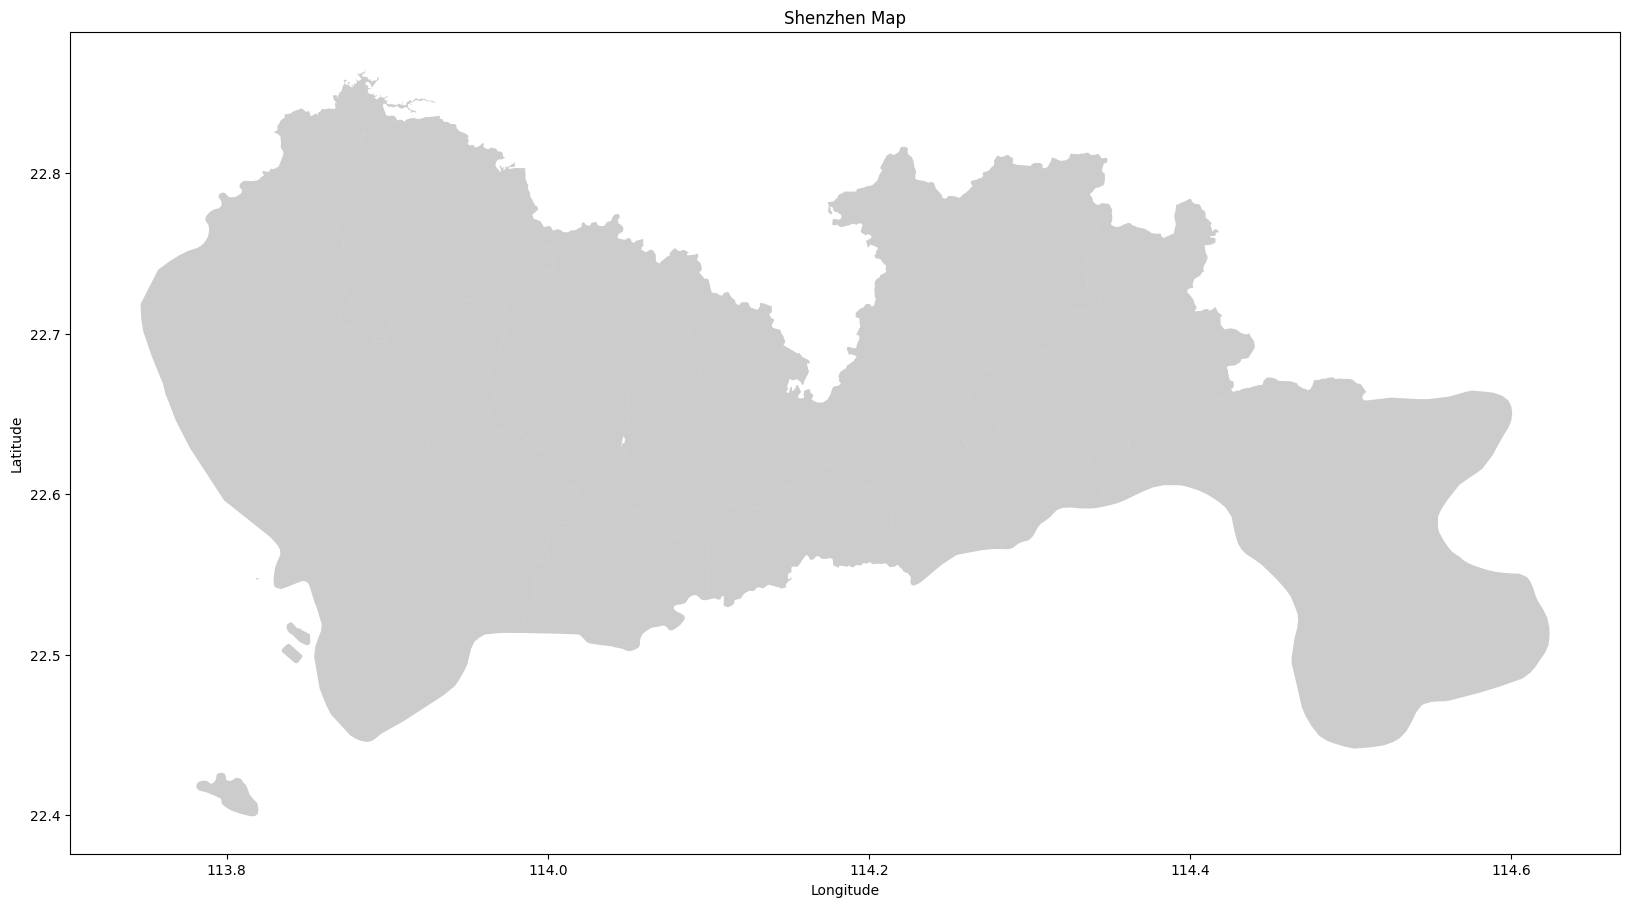

In [ ]:
#Visualize
plot_shenzhen()

We overlap the trip starting points and ending points on the map above. To do this, we will first need to create geodataframes from the trip start and end coordinates from the data we processed above. Then we will have to plot the trip start/end geodataframe along with the Shenzhen geodataframe. Luckily, our plot_shenzhen function handles all these steps, so we can call it with the columns corresponding to the trip starting positions and ending positions. This yields the two plots below:

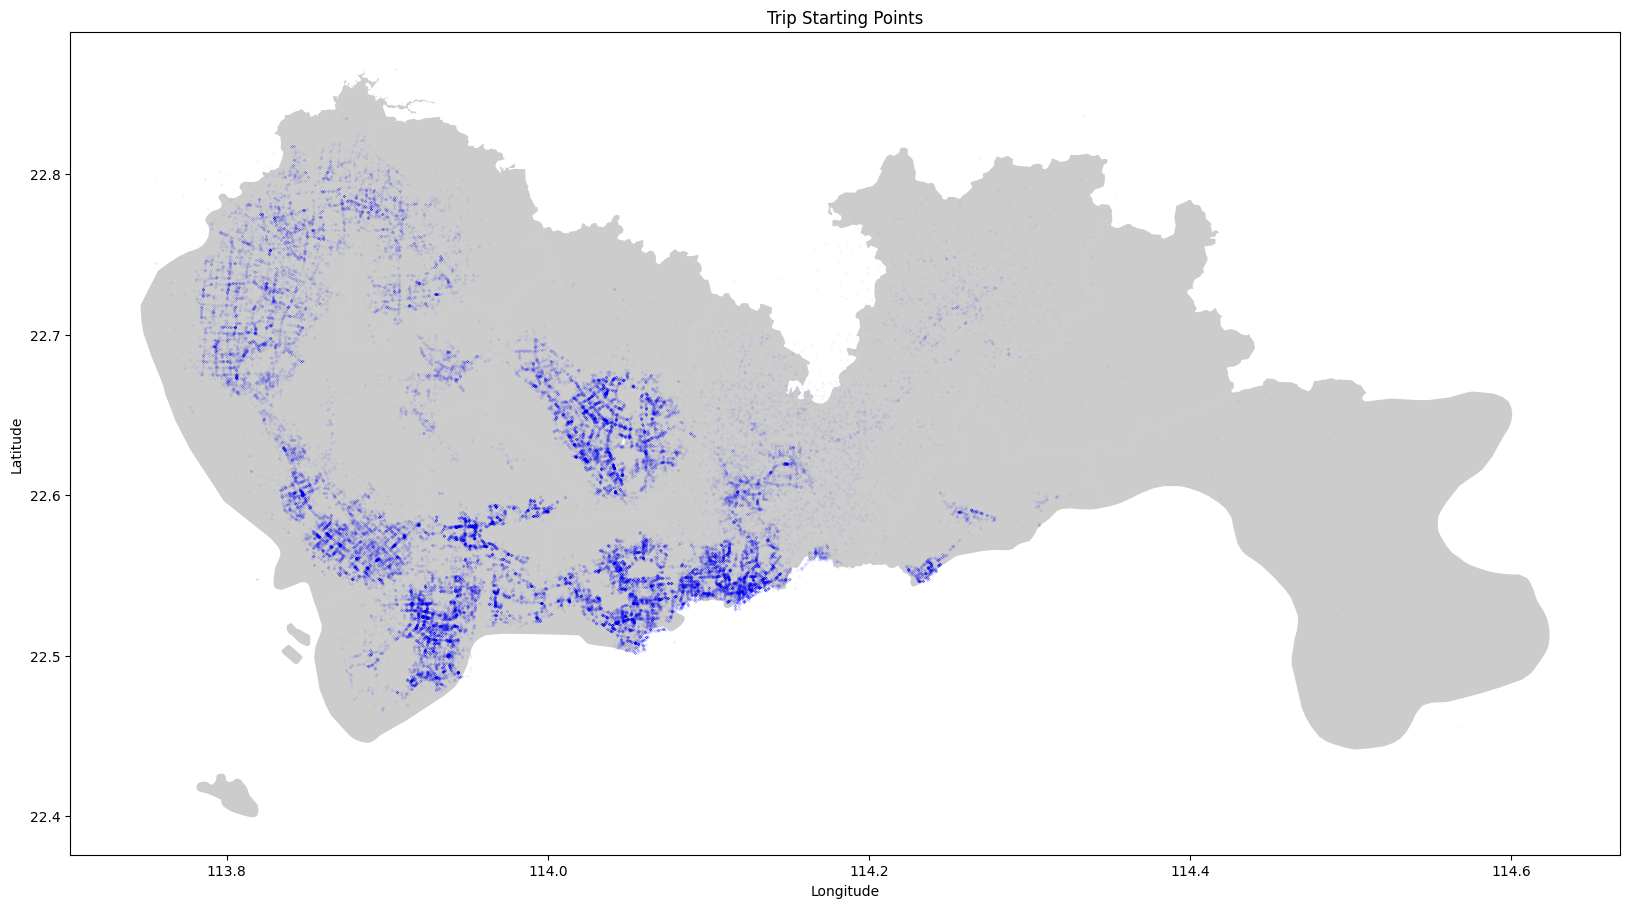

In [ ]:
#PLOT TRIP STARTING POINTS
plot_shenzhen('START_LAT', 'START_LNG', 'Trip Starting Points')

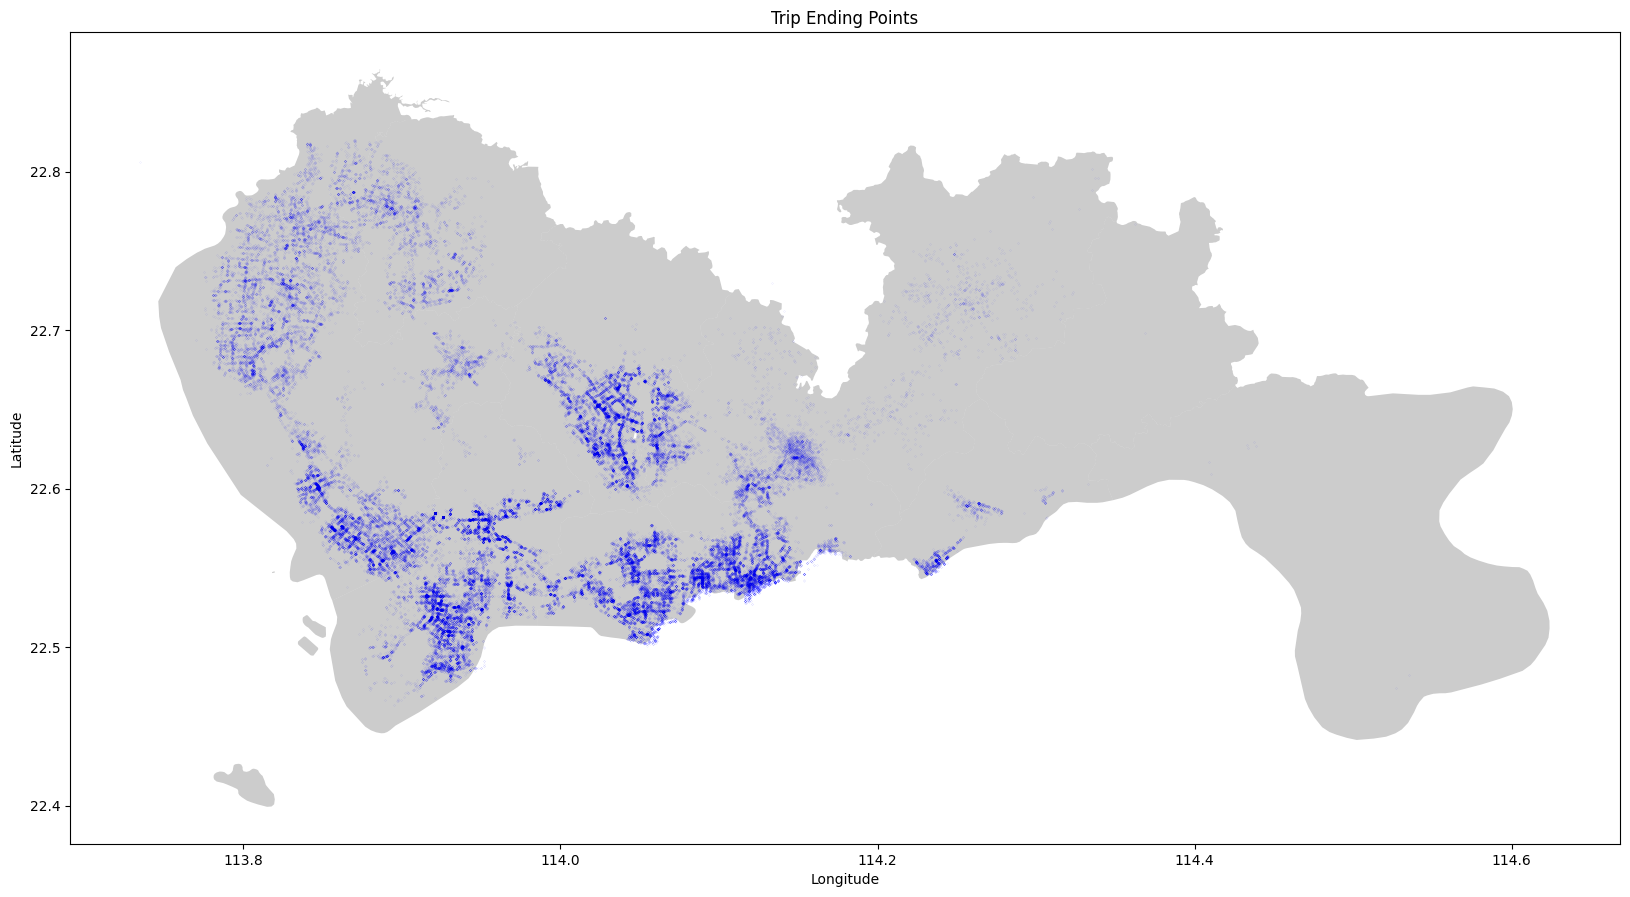

In [ ]:
#PLOT TRIP ENDING POINTS
plot_shenzhen('END_LAT', 'END_LNG', 'Trip Ending Points')

Notice that the start and end plots look similar. In fact what we are plotting here are actually bike stands from which bikers borrow and return bikes. We can now investigate the POIs (restaurants, stadiums, offices, stations, etc.) that exist around these bike stands to get a sense for where the bikers are headed.

The process of loading and visualizing the POI data from shape files is similar to above. Again, since loading all the POI shape files and plotting them will be time-consuming, we load a subset of the POI categories.

In [ ]:
#Set path to shapefile directory
poi_dir_path = "/content/data/Shenzhen Bike-Share Data/ShenzhenPOI/ShapeFile/"

Before we can select the POI categories we are interested in, we need to find out what POI categories exist. This information is stored in the amap_poicode.xlsx file in the ShenzhenPOI folder.

In [ ]:
#Find all POI Types
poi_types_df = pd.read_excel("/content/data/Shenzhen Bike-Share Data/ShenzhenPOI/amap_poicode.xlsx")
poi_types_df.head()

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,序号,NEW_TYPE,大类,中类,小类,Big Category,Mid Category,Sub Category
0,1,10000,汽车服务,汽车服务相关,汽车服务相关,Auto Service,Automobile Service Related,Automobile Service Related
1,2,10100,汽车服务,加油站,加油站,Auto Service,Filling Station,Filling Station
2,3,10101,汽车服务,加油站,中国石化,Auto Service,Filling Station,Sinopec
3,4,10102,汽车服务,加油站,中国石油,Auto Service,Filling Station,PetroChina
4,5,10103,汽车服务,加油站,壳牌,Auto Service,Filling Station,Shell


Each POI category is further sub-divided into smaller categories. Let's assume that we are not interested in the sub-categories. We will need to find all the unique categories stored in the "Big Category" attribute above.

In [ ]:
unique_poi_types = poi_types_df['Big Category'].drop_duplicates().values

print(unique_poi_types)

['Auto Service' 'Auto Dealers' 'Auto Repair' 'Motorcycle Service'
 'Food & Beverages' 'Shopping' 'Daily Life Service' 'Sports & Recreation'
 'Medical Service' 'Accommodation Service' 'Tourist Attraction'
 'Commercial House' 'Governmental Organization & Social Group'
 'Science/Culture & Education Service' 'Culture & Education'
 'Transportation Service' 'Finance & Insurance Service' 'Enterprises'
 'Road Furniture' 'Place Name & Address' 'Public Facility'
 'Incidents and Events' 'Indoor facilities' 'Pass Facilities']


Next, we have to sanitize the category names by removing whitespaces and some special characters. We have to do this because the shape file names corresponding to these categories contain sanitized category names and we want to  select the shape files for the categories we are interested in.

In [ ]:
for i, poi in enumerate(unique_poi_types):
  for c in [' ', '&', '/']:
     unique_poi_types[i] = unique_poi_types[i].replace(c, '')

print(unique_poi_types)

['AutoService' 'AutoDealers' 'AutoRepair' 'MotorcycleService'
 'FoodBeverages' 'Shopping' 'DailyLifeService' 'SportsRecreation'
 'MedicalService' 'AccommodationService' 'TouristAttraction'
 'CommercialHouse' 'GovernmentalOrganizationSocialGroup'
 'ScienceCultureEducationService' 'CultureEducation'
 'TransportationService' 'FinanceInsuranceService' 'Enterprises'
 'RoadFurniture' 'PlaceNameAddress' 'PublicFacility' 'IncidentsandEvents'
 'Indoorfacilities' 'PassFacilities']


For this tutorial, let's assume that we are interested in medical and transportation services, and sports and rec facilities only.

In [ ]:
#Define POI categories we want to select
poi_cat = ['SportsRecreation', 'TransportationService', 'MedicalService']

In [ ]:
#Load poi shape files
shp_files = []
for file_path in os.listdir(poi_dir_path):
  if file_path.endswith(".shp"):
    for cat in poi_cat:
      if cat in file_path:
        shp_file = gpd.read_file(os.path.join(poi_dir_path, file_path))
        shp_file['POI_TYPE'] = cat
        shp_files.append(shp_file)
        continue

In [ ]:
#Create geo dataframe from all POIs
poi_gdf = pd.concat(shp_files).pipe(gpd.GeoDataFrame)
poi_gdf.describe(include='all', datetime_is_numeric=True)

,geometry,POI_TYPE
count,80237,80237
unique,80009,3
top,POINT (113.96224097276098 22.70804055426153),TransportationService
freq,4,35387


In [ ]:
print(poi_gdf.columns.tolist())

['geometry', 'POI_TYPE']


Text(203.97222222222223, 0.5, 'Latitude')

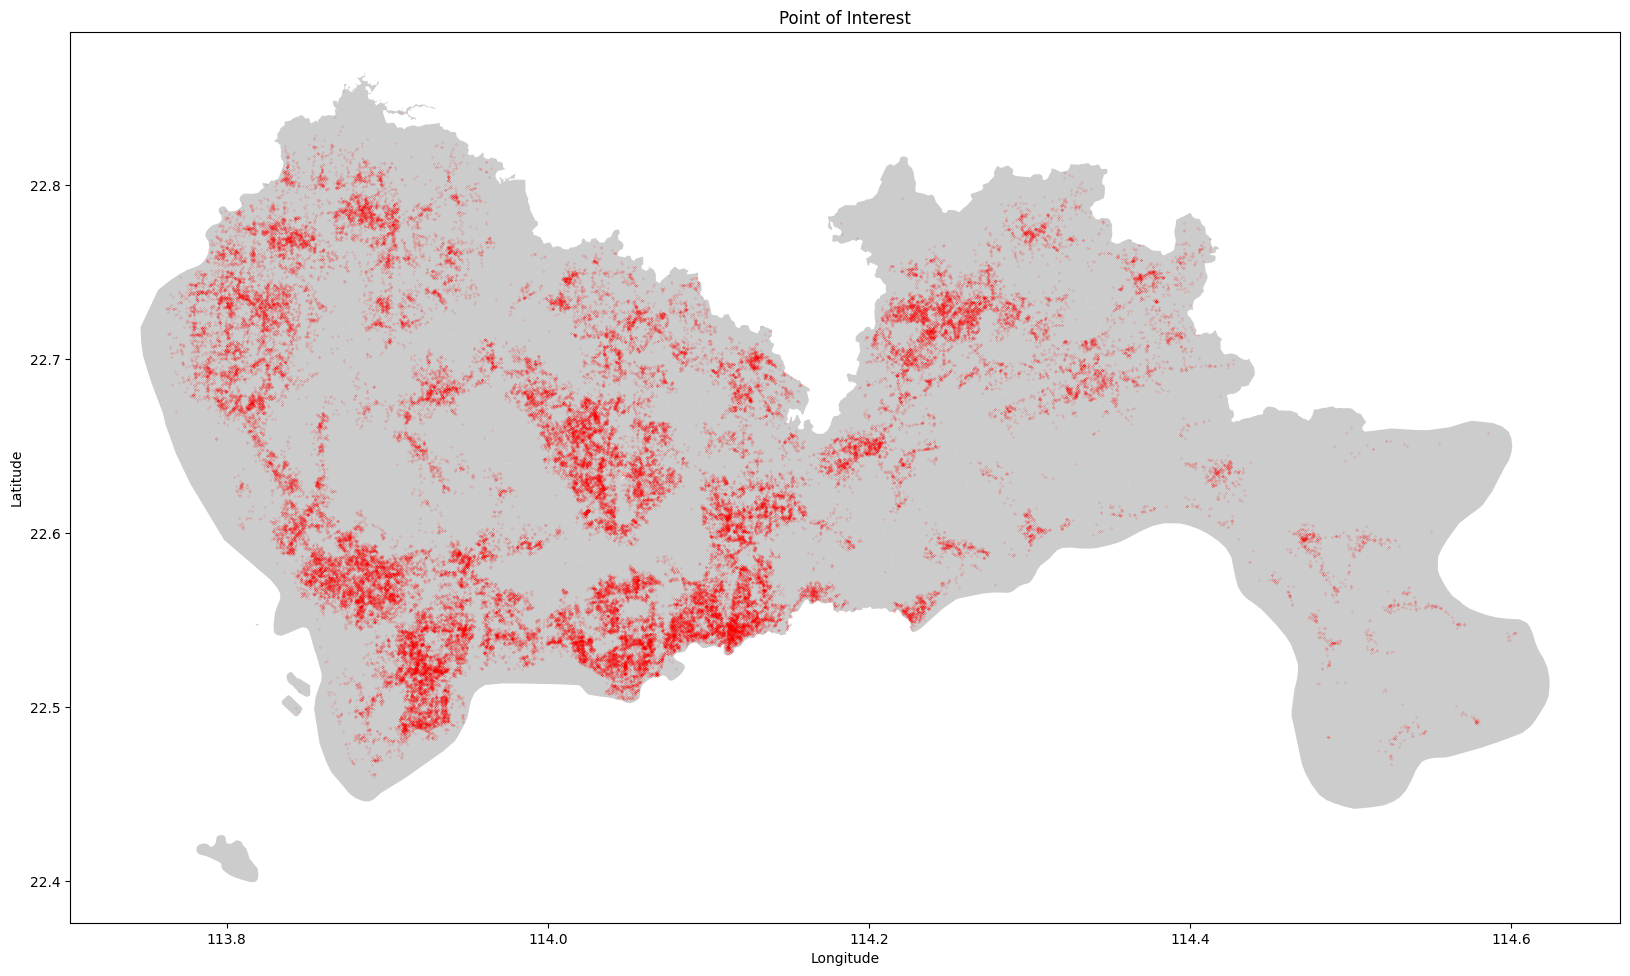

In [ ]:
#Visualize
poi_plot, ax = plt.subplots(figsize = (20, 20))
shenzhen.plot(ax=ax, alpha=0.4, color='grey')
poi_gdf.plot(ax=ax, markersize = 0.01, color = 'r')
ax.set_title('Point of Interest')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

We have a good distribution of our selected POIs around the trip starting and ending points. So we can hope that we can model some kind of relationship between the trips and these POIs. But first, we have to save our POI geodataframe so that we can reuse it later.

In [ ]:
#Prepare directory to save poi geodataframe
compiled_poi_path = '/content/data/Shenzhen Bike-Share Data/poi_compiled'

#Delete folder if it already exists
if os.path.exists(compiled_poi_path):
  shutil.rmtree(compiled_poi_path)

os.mkdir(compiled_poi_path)

In [ ]:
#Save poi gdf
poi_gdf.to_file(compiled_poi_path + '/compiled.shp', encoding='UTF-8')

<a name="methodology"></a>
# Methodology

Our goal is to investigate the influence of POIs on trip ending points.

We will first generate POI and trip densities using kernel density estimation (KDE). KDE allows us to estimate the distribution of our trip ending points and POIs. KDE is computed using a kernel function such as the normal distribution. The kernel function is applied at each data point to calculate the contribution of that data point to the overall distribution. Once the kernel function has been computed at each point, we add up all the results to derive the the probability density of our data.

Packages such as seaborn automate this process for us. Below, we will be using the kdeplot function in seaborn to compute and plot the distribution of our POIs and trip endings. Seaborn's kdeplot uses a Guassian (normally distributed) kernel by default.

We start by creating some helper functions. The seaborn kde plot consists of polygons that we can save as geodataframes for later use. The function below parses all polygons in the plot and creates one polygon per contour level. It then saves all the polygons as a geodataframe that can be read and plotted without having to recompute the kernel densities.

In [ ]:
#Saves the contours generated by sns.kdeplot as gdfs
def save_density_contours(plot, crs, save_path):
  level_polygons = []

  for i,col  in enumerate(plot.collections):
      paths = []
      # Loop through all polygons that have the same intensity level
      for contour in col.get_paths():
          # Create a polygon for the countour
          for ncp, cp in enumerate(contour.to_polygons()):
              x = cp[:,0]
              y = cp[:,1]
              new_shape = Polygon([(i[0], i[1]) for i in zip(x,y)])
              if ncp == 0:
                  poly = new_shape
              else:
                  poly = poly.difference(new_shape) # Remove holes, if any
          paths.append(poly)

      multi = MultiPolygon(paths) #MultiPolygon for contour
      level_polygons.append((i/100, multi))

  # Create GeoDataFrame
  density_df = pd.DataFrame(level_polygons, columns =['level', 'geometry'])
  density_gdf = gpd.GeoDataFrame(density_df, geometry='geometry', crs = crs)

  #Delete folder if it already exists
  if os.path.exists(save_path):
    shutil.rmtree(save_path)

  os.mkdir(save_path)

  density_gdf.to_file(save_path + '/compiled.shp', encoding='UTF-8')

The compute_density function below calls sns.kdeplot to compute and plot the kde of the inputs and then saves the plot's polygons using our save_density_contours function above. It also overlays the densities over a map of Shenzhen.

In [ ]:
def compute_density(data, x, y, title, ax=None, save_gdf = False):
  if not ax:
    kde_plt_ax = sns.kdeplot(data = data, x=x, y=y, fill=True)
  else:
    kde_plt_ax = ax
  shenzhen.plot(ax=kde_plt_ax, facecolor='None')
  kde_plt_ax.set_title(title)
  kde_plt_ax.set_xlabel("Longitude")
  kde_plt_ax.set_ylabel("Latitude")

  if save_gdf:
    save_density_contours(kde_plt_ax, shenzhen.crs, '/content/data/Shenzhen Bike-Share Data/' + title.strip() + '_polygon')

## POI Densities


We can now use the functions we created to plot the densities of our POIs. We pass in the geodataframe containing our POI information and the attributes representing latitude and longitude coordinates into compute_density.

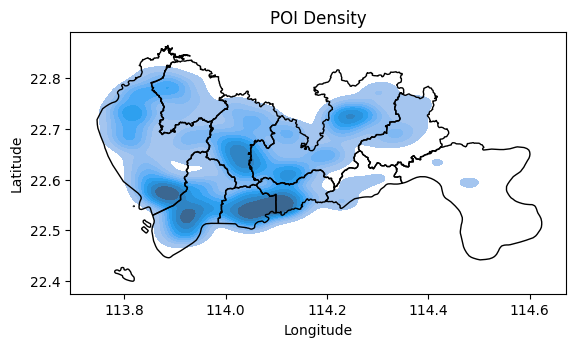

In [ ]:
compute_density(poi_gdf, poi_gdf.geometry.x, poi_gdf.geometry.y, 'POI Density', save_gdf=True)

Notice that the plot above is similar to the POI plot with red circles we created earlier. However, instead of distinct points, we have a smooth distribution. We use KDE to create this smooth distribution from the distinct points.

#Trip Densities

Next, let's perform KDE on our trip end points.

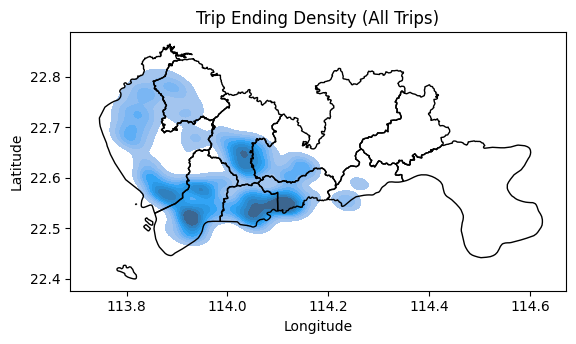

In [ ]:
compute_density(df, 'END_LNG', 'END_LAT', 'Trip Ending Density (All Trips)', save_gdf=True)

Our trip end point densities are roughly around the same areas compared to our POIs. Since we selected only a small subset of our trip data, there are a lot of areas in the plot that are not covered by our density estimation. This could either mean that we have excluded most trips that ended in those areas or those areas do not have sufficient shared-bike coverage. A good exercise would be to plot the trip ending densities of all of our trip data and investigate how the plots differ.

**Trip endings based on day of week**

We can use the weekday vs. weekend attribute that we added to our data to investigate how trip ending densities are different depending on whether it is a weekday or the weekend.

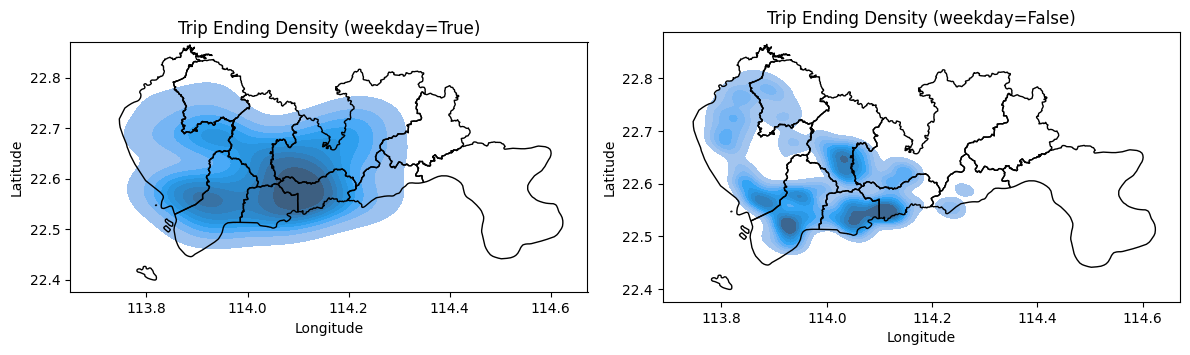

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

for i, condition in enumerate([True, False]):
  kde_plt_ax = sns.kdeplot(df.loc[df['IS_WEEKDAY'] == condition], x='END_LNG', y='END_LAT', fill=True, ax=axes[i%2])
  shenzhen.plot(ax=kde_plt_ax, facecolor='None')
  kde_plt_ax.set_title('Trip Ending Density (weekday='+ str(condition)  +')')
  kde_plt_ax.set_xlabel("Longitude")
  kde_plt_ax.set_ylabel("Latitude")

plt.tight_layout()

We can see clear differences between where trips are ending on the weekend and on weekdays. We have fewer datapoints for weekends than for weekdays. Comparing these plots to plots of different types of POI can help us determine whether bikers are headed to different locations based on the day of the week.

**Trip endings based on time of day**

We can use the time window attribute that we added to our data to investigate how trip ending densities differ based on the time of day.

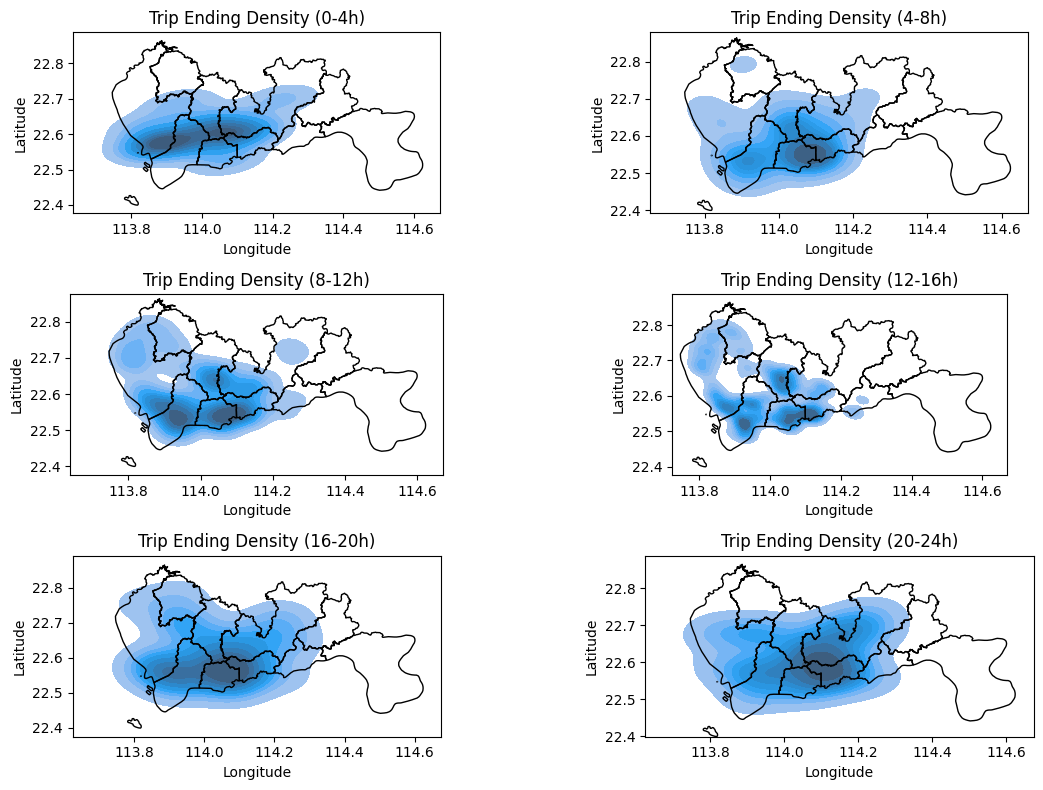

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))

for i, bin in enumerate(time_labels):
    row = i // 2
    col = i % 2
    kde_plt_ax = sns.kdeplot(df.loc[df['TIME_WINDOW'] == bin], x='END_LNG', y='END_LAT', fill=True, ax=axes[row, col])
    shenzhen.plot(ax=kde_plt_ax, facecolor='None')
    kde_plt_ax.set_title('Trip Ending Density (' + bin +')')
    kde_plt_ax.set_xlabel("Longitude")
    kde_plt_ax.set_ylabel("Latitude")

plt.tight_layout()

Again, there are differences in trip ending points based on time of day. Some of these differences can be attributed to differences in data availability for different time windows. Nevertheless, we can analyze the plots along with plots of POIs to find out bike sharing usage patterns.

Exercise for participants:
Would the trip densities in the above time-window plots be different if we differentiated between weekday and weekend windows?

KDE can therefore be used to analyze our trip data and formulate hypotheses around shared-bike usage patterns. These hypotheses need can be validated by analyzing other data.

## Linear Regression
Now, let's try to find a relationship between the trip ending densities and POI densities. For now, we will assume that the two densities are linearly related.

To perform regression, we first perform KDE once again. However, since we are not creating plots here, and we need to know the actual density of POIs and trip endings are particular latitude/longitude coordinates, we do not use seaborn kdeplot to generate the estimates. Instead, generate a grid of points separated from each other by 1000 meters all over Shenzhen. Then we compute the densities of POIs and trips at each of these points. Lastly, we perform linear regression using these densities to investigate the effect of POI densities on trip densities.

First, we create/load the geodataframes for trip endings and POIs.

In [ ]:
#GENERATE KERNELS AND DENSITIES
trip_geometry = [Point(xy) for xy in zip(df['END_LNG'], df['END_LAT'])]
trips = gpd.GeoDataFrame(df, geometry=trip_geometry, crs = shenzhen.crs)
pois = gpd.read_file(compiled_poi_path)

The code below creates the grid of points. It then uses the gaussian_kde function from the scipy.stats package to make density estimations for POIs and trips at each of these grid points.

In [ ]:
# Create grid of evenly distributed points
bandwidth = 1000
xmin, ymin, xmax, ymax = trips.total_bounds

xcoords = np.arange(xmin, xmax, bandwidth/111000)
ycoords = np.arange(ymin, ymax, bandwidth/111000)
X, Y = np.meshgrid(xcoords, ycoords)
kernels = np.vstack([X.ravel(), Y.ravel()])
grid_geometry = [Point(x, y) for y in ycoords for x in xcoords]
grid_gdf = gpd.GeoDataFrame(geometry=grid_geometry)

# KDE for POIs
poi_densities = {}
for poi_type in pois['POI_TYPE'].unique():
    poi_type_data = pois[pois['POI_TYPE'] == poi_type]
    poi_coords = np.column_stack((poi_type_data.geometry.x, poi_type_data.geometry.y))
    poi_kernel = gaussian_kde(poi_coords.T, bw_method=bandwidth/111000)
    dens = np.reshape(poi_kernel(kernels).T, X.shape)
    poi_densities[poi_type] = dens

# KDE for trips
trip_coords = np.column_stack((trips.geometry.x, trips.geometry.y))
trip_kernel = gaussian_kde(trip_coords.T)
trip_densities = np.reshape(trip_kernel(kernels).T, X.shape)

We then fit a LinearRegression model from sklearn.linear_model and try to find a linear relationship between the POI and trip densities we generated at each point on the grid.

In [ ]:
results = {}
for poi_type, density in poi_densities.items():
    y = trip_densities.ravel()
    X = density.ravel().reshape(-1,1)

    # perform linear regression
    lm = LinearRegression()
    lm.fit(X, y)

    # store the results in the dictionary
    results[poi_type] = {
        'coefficients': lm.coef_,
        'intercept': lm.intercept_,
        'score': lm.score(X, y)
    }

# print the results
for poi_type in poi_densities:
    print(poi_type)
    print('Coefficients:', results[poi_type]['coefficients'])
    print('Intercept:', results[poi_type]['intercept'])
    print('R-squared:', results[poi_type]['score'])
    print()

TransportationService
Coefficients: [0.57361097]
Intercept: 1.4388721709946801
R-squared: 0.4502098165085624

SportsRecreation
Coefficients: [0.32501613]
Intercept: 2.33296040043609
R-squared: 0.2727380309191403

MedicalService
Coefficients: [0.3596849]
Intercept: 2.258073618657201
R-squared: 0.2643561547871396



The R-squared score represents the correlation between POI and trip ending densities. The higher the correlation, the better our model is at representing the relationship between POIs and trip endings.

Now, let's combine all predictors and see what predictive performance we can reach.

In [ ]:
x1 = poi_densities['MedicalService'].reshape(-1)
x2 = poi_densities['SportsRecreation'].reshape(-1)
x3 = poi_densities['TransportationService'].reshape(-1)

X = np.stack([x1,x2,x3],axis=1)
y = trip_densities.ravel()

# perform linear regression
lm = LinearRegression()
lm.fit(X, y)
y_pred_lm = lm.predict(X)

print('Coefficients:', lm.coef_)
print('Intercept:', lm.intercept_)
print('R-squared:', lm.score(X, y))

Coefficients: [0.02554455 0.05813858 0.49597901]
Intercept: 1.4257263731379166
R-squared: 0.45684034339449564


## Graph Neural Network (GNN)
Our trip densities follow some clear spatial patterns. This is something simple linear models cannot capture. Instead, we can deploy a model with the capacity to account for and learn from spatial dependencies. For example, a GNN.

First, we need to construct an input graph. This can be done by using the spatial coordinates (latitude and longitude) of our grid cells to obtain a $k$-nearest-neighbor graph. We also normalize our input and output before feeding it to the GNN.

In [ ]:
from torch_geometric.nn import knn_graph
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F

c = torch.tensor(np.stack([grid_gdf.geometry.x.values.reshape(-1),grid_gdf.geometry.y.values.reshape(-1)],axis=1))

X = torch.tensor(X)
y = torch.tensor(y)

y = F.normalize(y,dim=0)
X = F.normalize(X,dim=1)

k = 5
edge_index = knn_graph(c, k=k, loop=False)
graph_data = Data(x=X, y=y, edge_index=edge_index, pos=c)

We now define our GNN. Let's start with a simple Graph Convolutional Network (GCN) with two convolutional layers and a linear prediction head.

In [ ]:
class GCN(nn.Module):
    """
        A simple GCN with two convolutional layers
    """
    def __init__(self, num_features_in=3, num_features_out=1, hidden_dim=32, dropout=False):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features_in, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_features_out)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = x.float()
        h1 = F.relu(self.conv1(x, edge_index))
        if self.dropout:
          h1 = F.dropout(h1, training=self.training)
        h2 = F.relu(self.conv2(h1, edge_index))
        if self.dropout:
          h2 = F.dropout(h2, training=self.training)
        output = self.fc(h2)
        return output

Now we need to set our training hyperparameters: How many epochs do we want to train? What learning rate and which optimizer do we want to use? Which loss function do we want to use? Which hyperparameters (e.g. hidden dimensions) should our GNN have?

In [ ]:
lr = 1e-3
n_epochs = 10000
print_freq = 1000

model = GCN(num_features_in=3, num_features_out=1, hidden_dim=32, dropout=False)
loss_fun = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

if 'range' in globals(): #Delete range from earlier
  del range

Let's train the GNN!

In [ ]:
# Training loop
it_counts = 0
for epoch in range(n_epochs):
  it_counts += 1
  model.train()
  out = model(graph_data.x.float(), graph_data.edge_index)
  optimizer.zero_grad()
  loss = loss_fun(graph_data.y.float().reshape(-1), out.reshape(-1))
  loss.backward()
  optimizer.step()
  if it_counts % print_freq == 0:
    print('Loss:', loss.item())

Loss: 8.856979547999799e-05
Loss: 7.930692663649097e-05
Loss: 7.452410500263795e-05
Loss: 6.99139927746728e-05
Loss: 6.714044866384938e-05
Loss: 6.473579560406506e-05
Loss: 6.289194425335154e-05
Loss: 6.257455243030563e-05
Loss: 5.9756104747066274e-05
Loss: 5.8339333918411285e-05


Training is done! We can obtain predictions and compute the R-squared score.

In [ ]:
from sklearn.metrics import r2_score

with torch.no_grad():
  model.eval()
  y_pred_gnn = model(graph_data.x.float(), graph_data.edge_index)

gnn_r2 = r2_score(graph_data.y, y_pred_gnn)
print("GNN R-squared:", gnn_r2)

GNN R-squared: 0.7492674220871809


<a name="results-and-discussion"></a>
# Results & Discussion



How do predictions made by the linear model and our GNN compare?

Text(0.5, 1.0, 'Predicted (GNN)')

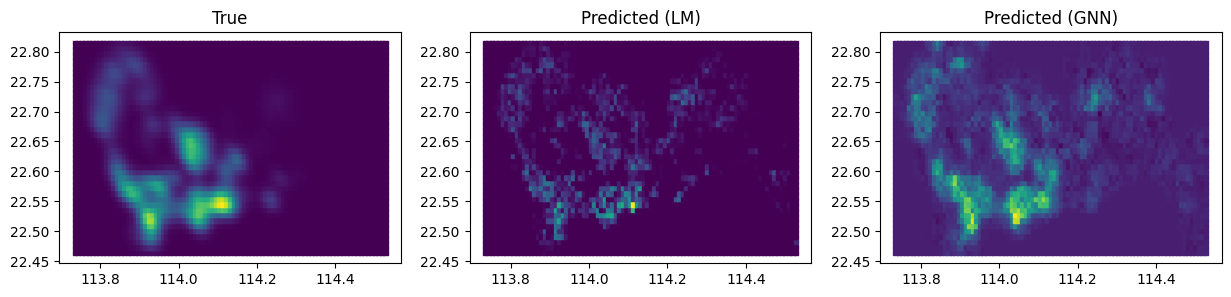

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(15, 3))
ax[0].scatter(c[:,0], c[:,1], c=graph_data.y.reshape(-1), cmap='viridis',marker="s",s=10)
ax[0].set_title('True')
ax[1].scatter(c[:,0], c[:,1], c=y_pred_lm.reshape(-1), cmap='viridis',marker="s",s=10)
ax[1].set_title('Predicted (LM)')
ax[2].scatter(c[:,0], c[:,1], c=y_pred_gnn.detach().reshape(-1), cmap='viridis',marker="s",s=10)
ax[2].set_title('Predicted (GNN)')

To get a more realistic idea of how well (or not) our models perform out-of-sample, let's split our data in training and testing set

In [ ]:
from sklearn.model_selection import train_test_split

def random_split(coordinates, train_size=0.8, random_state=0):
    """
    Simple random train / test split
    """
    n = coordinates.shape[0]
    indices = np.arange(n)
    _, _, _, _, train_index, test_index = train_test_split(coordinates, coordinates, indices, test_size=(1-train_size), random_state=random_state)
    return train_index, test_index

train_size = 0.7
idx_train, idx_test = random_split(c,train_size=train_size)

train_x, test_x = X[idx_train], X[idx_test]
train_y, test_y = y[idx_train], y[idx_test]
train_c, test_c = c[idx_train], c[idx_test]

Let's plot train and test set.

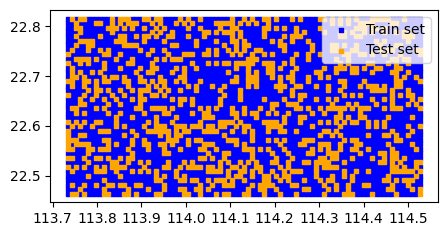

In [ ]:
plt.figure(figsize=(5,2.5))
plt.scatter(train_c[:,0], train_c[:,1], c='blue',marker="s",s=10,label="Train set")
plt.scatter(test_c[:,0], test_c[:,1], c='orange',marker="s",s=10,label="Test set")
plt.legend()

Now, we train linear regression and a GNN on the training data.

In [ ]:
# perform linear regression
lm = LinearRegression()
lm.fit(train_x, train_y)
y_pred_train_lm = lm.predict(train_x)
y_pred_test_lm = lm.predict(test_x)

lm_train_r2 = r2_score(train_y, y_pred_train_lm)
lm_test_r2 = r2_score(test_y, y_pred_test_lm)
print("LM - Train R-squared:", lm_train_r2)
print("LM - Test R-squared:", lm_test_r2)

LM - Train R-squared: 0.24694388961226654
LM - Test R-squared: 0.2409772281670005


In [ ]:
#perform GNN training
lr = 1e-3
n_epochs = 10000
print_freq = 1000

train_edge_index = knn_graph(train_c, k=k, loop=False)
test_edge_index = knn_graph(test_c, k=k, loop=False)

graph_data_train = Data(x=train_x, y=train_y, edge_index=train_edge_index, pos=train_c)
graph_data_test = Data(x=test_x, y=test_y, edge_index=test_edge_index, pos=test_c)

model = GCN(num_features_in=3, num_features_out=1, hidden_dim=32, dropout=False)
loss_fun = nn.L1Loss() #Use L1 loss to prevent overfitting
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

it_counts = 0
for epoch in range(n_epochs):
  it_counts += 1
  model.train()
  out = model(graph_data_train.x.float(), graph_data_train.edge_index)
  optimizer.zero_grad()
  loss = loss_fun(graph_data_train.y.float().reshape(-1), out.reshape(-1))
  loss.backward()
  optimizer.step()
  if it_counts % print_freq == 0:
    print('Loss:', loss.item())

Loss: 0.004649646580219269
Loss: 0.0042638760060071945
Loss: 0.004163241479545832
Loss: 0.0039599062874913216
Loss: 0.004050917457789183
Loss: 0.003881992306560278
Loss: 0.0038709219079464674
Loss: 0.003886285237967968
Loss: 0.0037589562125504017
Loss: 0.0036607077345252037


In [ ]:
with torch.no_grad():
  model.eval()
  y_pred_train_gnn = model(graph_data_train.x.float(), graph_data_train.edge_index)
  y_pred_test_gnn = model(graph_data_test.x.float(), graph_data_test.edge_index)

gnn_train_r2 = r2_score(train_y, y_pred_train_gnn)
gnn_test_r2 = r2_score(test_y, y_pred_test_gnn)
print("GNN - Train R-squared:", gnn_train_r2)
print("GNN - Test R-squared:", gnn_test_r2)

GNN - Train R-squared: 0.7173898797317575
GNN - Test R-squared: 0.30075933632557394


We notice that our GNN models our data better than the linear model. This could be because GNNs take advantage of the spatial patterns in the data, while linear models are not capable of doing so.

Developing accurate models of the relationship between POIs and trip densities allows us to understand bike-sharing usage patterns. This patterns can be used to make sure that there are enough bikes at stands to meet demand. It can also inform where to set up new bike stands. Analyzing the POIs and geographic regions with low trip densities may reveal lack of biking infrastructure such as bike lanes, bike stands, etc. or other issues that need to be addressed.

A good first step towards inproving our model would be to train on our whole dataset with the whole range of POIs. Our models should also take into account the temporal dimension of our data (time/day/month).

## Limitations
* Both of our models are constrained by the data we provide to it. We have used subsets of the data in this tutorial so that it runs within a reasonable amount of time. Using all the data may or may not lead to better results.
* If our goal is to improve climate change-related outcomes by promoting greener modes of transportation, we should not assume that bikers and car-users have the same travelling patterns even though it does feel like there is a strong relationship between the two.

## Next Steps
* How does using all the trip data instead of a subset affect the performance of our models?
* How can our models be used to determine where bikers are headed at different times of the day and different times of the week?
* How can our models be used to determine where to install new bike stands?
* The data folder contains a map of the bike paths in Shenzhen. How does the existence and/or non-existence of bike paths affect trip densities?



<a name="references"></a>
# References

* Willing, Christoph, Konstantin Klemmer, Tobias Brandt, and Dirk Neumann. “Moving in Time and Space – Location Intelligence for Carsharing Decision Support.” Decision Support Systems 99 (July 2017): 75–85. https://doi.org/10.1016/j.dss.2017.05.005.

* Wagner, Felix, Nikola Milojevic-Dupont, Lukas Franken, Aicha Zekar, Ben Thies, Nicolas Koch, and Felix Creutzig. “Using Explainable Machine Learning to Understand How Urban Form Shapes Sustainable Mobility.” Transportation Research Part D: Transport and Environment 111 (October 2022): 103442. https://doi.org/10.1016/j.trd.2022.103442.

* Geng X, Li Y, Wang L, Zhang L, Yang Q, Ye J, Liu Y (2019) Spatiotemporal multigraph convolution network for ride-hailing demand forecasting. In: Proceedings
of the AAAI conference on artificial intelligence, vol 33, pp 3656–3663
